In [2]:
import sys
print(f"Environment: {sys.executable}")

Environment: /home/peromoseq/anaconda3/envs/mmdeploy/bin/python3


In [11]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
model_directory = Path("/n/groups/datta/tim_sainburg/datasets/scratch/mm_training/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-08-15-10-35-59/")

In [5]:
!ls {model_directory}

20240815_103613  epoch_10.pth	  rtmdet_s_8xb32-300e_coco.py
config.py	 last_checkpoint


In [6]:
config_loc = model_directory / 'config.py'
checkpoint_loc = config_loc.parent / 'epoch_10.pth'

In [7]:
log_file = np.sort(list(model_directory.glob('*/*.log')))[-1]
with open(log_file, 'r') as file:
    log_info = file.read()
loss_lines = [i for i in log_info.split('\n') if ' loss: ' in i]
loss = [float(i.split('  loss: ')[1].split('  loss_cls:')[0]) for i in loss_lines]

Text(0, 0.5, 'Training Loss')

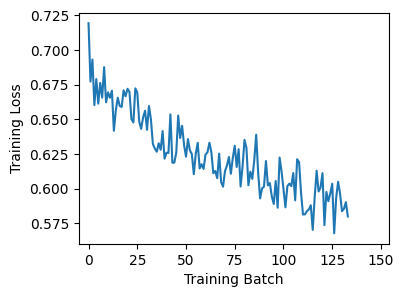

In [8]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(np.arange(len(loss[20:])), loss[20:])
ax.set_xlim([-5, len(loss)])
ax.set_xlabel('Training Batch')
ax.set_ylabel('Training Loss')

### Load the inferencer

In [1]:
from mmdet.apis import DetInferencer

In [9]:
# Choose to use a config
config = config_loc.as_posix()
# Setup a checkpoint file to load
checkpoint = checkpoint_loc.as_posix()
# Set the device to be used for evaluation
device = 'cuda:0'

In [10]:
# Initialize the DetInferencer
inferencer = DetInferencer(config, checkpoint, device)

Loads checkpoint by local backend from path: /n/groups/datta/tim_sainburg/datasets/scratch/mm_training/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-08-15-10-35-59/epoch_10.pth
08/15 11:34:52 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


/home/peromoseq/anaconda3/envs/mmdeploy/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [16]:
# load a test image
sample_image = "/n/groups/datta/tim_sainburg/projects/24-01-05-multicamera_keypoints_mm2d/example_data/test_mouse.png"
image = Image.open(sample_image)
image_array = np.array(image)
image_array.shape

(1200, 1920, 4)

In [17]:
# run inference
result = inferencer(image_array[:,:,:3], out_dir='/tmp', pred_score_thr=0.3)

Output()

/home/peromoseq/anaconda3/envs/mmdeploy/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: 
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at
/opt/conda/conda-bld/pytorch_1702400400184/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

In [18]:
result.keys()

dict_keys(['predictions', 'visualization'])

(0.0, 10.0)

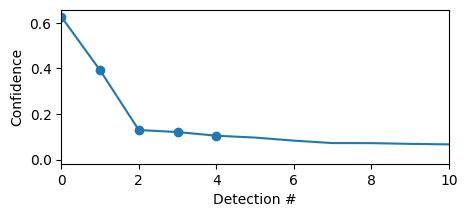

In [21]:
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(result['predictions'][0]['scores'])
ax.scatter(np.arange(5), result['predictions'][0]['scores'][:5])
ax.set_xlabel('Detection #')
ax.set_ylabel('Confidence')
ax.set_xlim([0,10])

### Plot detections

In [22]:
import matplotlib.patches as patches

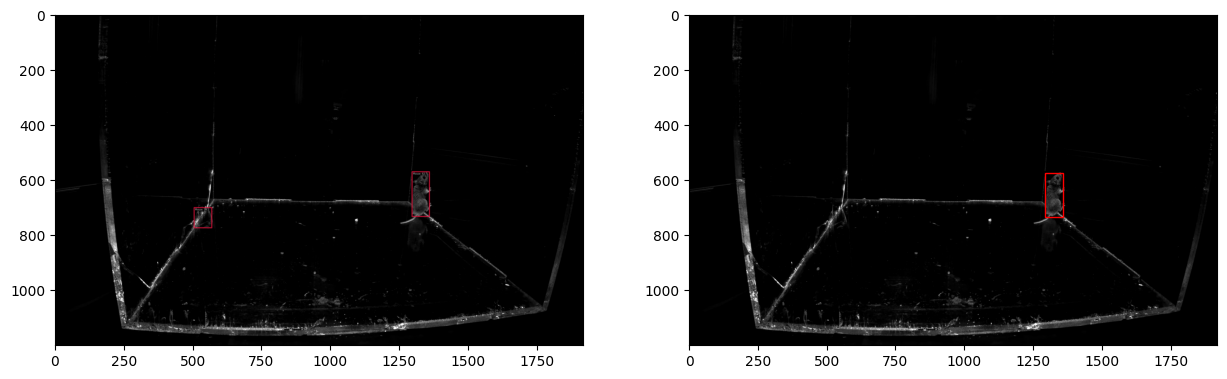

In [23]:
fig, axs = plt.subplots(figsize=(15,5), ncols=2)
axs[0].imshow(result['visualization'][0])

ax = axs[1]
ax.imshow(image_array)
for i in range(1):
    x_min, y_min, x_max, y_max = result['predictions'][0]['bboxes'][i]
    width = x_max - x_min
    height = y_max - y_min
    # Create a Rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    # Add the rectangle to the Axes
    ax.add_patch(rect)